In [155]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.cross_decomposition import CCA
import scipy.stats

In [156]:
def nwp_error(target, station, df):
    """
    Calculate the error between NWP model data and NYSM data for a specific target variable.

    Args:
        target (str): The target variable name (e.g., 't2m' for temperature).
        station (str): The station identifier for which data is being compared.
        df (pd.DataFrame): The input DataFrame containing NWP and NYSM data.

    Returns:
        df (pd.DataFrame): The input DataFrame with the 'target_error' column added.

    This function calculates the error between the NWP (Numerical Weather Prediction) modeldata and NYSM (New York State Mesonet) data for a specific target variable at a given station. The error is computed by subtracting the NYSM data from the NWP model data.
    """

    # Define a dictionary to map NWP variable names to NYSM variable names.
    vars_dict = {
        "t2m": "tair",
        "mslma": "pres",
        "tp": "precip_total",
        "u_total": "wspd_sonic_mean",
        # Add more variable mappings as needed.
    }

    # Get the NYSM variable name corresponding to the target variable.
    nysm_var = vars_dict.get(target)

    # Calculate the 'target_error' by subtracting NYSM data from NWP model data.
    target_error = df[f"{target}_{station}"] - df[f"{nysm_var}_{station}"]
    df.insert(loc=(1), column=f"{station}_target_error", value=target_error)

    return df

In [157]:
clim_div_df = pd.read_csv('/home/aevans/nwp_bias/src/landtype/data/nysm.csv')

In [158]:
clim_div_df = clim_div_df[clim_div_df['climate_division_name']=='Mohawk Valley']
stations = clim_div_df['stid'].tolist()
stations

['CAMD', 'HERK', 'JOHN', 'OPPE', 'SPRA', 'WEST']

In [159]:
df = pd.read_parquet('/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20240618/SPRA/06_18_2024_13:27:47_full_SPRA.parquet')
df.head()

,valid_time,valid_time_cos,valid_time_sin,target_error,t2m_CAMD,sh2_CAMD,d2m_CAMD,r2_CAMD,u10_CAMD,v10_CAMD,...,relh_WEST,srad_WEST,pres_WEST,mslp_WEST,wspd_sonic_mean_WEST,wspd_sonic_WEST,wmax_sonic_WEST,wdir_sonic_WEST,snow_depth_WEST,precip_total_WEST
0,2018-01-01 16:00:00,0.999853,0.017166,1.252294,-23.822256,0.00039,-27.665533,71.099998,-0.335041,0.032753,...,69.338226,333.268188,1004.473999,1007.870300,1.211264,1.273610,2.707442,63.085281,0.059557,0.0
1,2018-01-01 17:00:00,0.999853,0.017166,0.702930,-21.200110,0.00049,-25.236411,70.199997,-0.164658,0.586841,...,61.852631,429.464813,1003.306030,1006.588623,0.516806,0.381581,0.754610,152.326797,0.060917,0.0
2,2018-01-01 18:00:00,0.999853,0.017166,0.911966,-19.245795,0.00065,-21.984259,79.000000,-0.862186,0.063372,...,60.908211,420.306610,1002.354004,1005.292847,1.021998,0.563358,1.272481,92.698997,0.058384,0.0
3,2018-01-01 19:00:00,0.999853,0.017166,-0.314967,-17.692221,0.00074,-20.621466,78.300003,-0.675547,0.307129,...,60.364052,291.977112,1001.375977,1004.217896,1.212483,1.069508,1.490641,75.131889,0.058275,0.0
4,2018-01-01 20:00:00,0.999853,0.017166,-0.847188,-16.266638,0.00082,-19.354300,77.500000,-0.978044,0.145276,...,63.497349,158.532806,1000.788025,1003.661682,1.484138,1.338929,2.354090,61.432831,0.061441,0.0


In [160]:
for s in stations:
    df = nwp_error('t2m', s, df)

In [161]:
df = df.iloc[:,1:7]
df.head()

,WEST_target_error,SPRA_target_error,OPPE_target_error,JOHN_target_error,HERK_target_error,CAMD_target_error
0,0.115633,1.252294,0.475824,1.587463,-0.369376,-3.548096
1,-0.557820,0.702930,0.262100,0.727491,-0.581120,-3.703780
2,-3.070195,0.911966,-0.302004,0.691125,-0.712435,-3.635265
3,-3.888281,-0.314967,-0.530667,-0.035177,-1.159896,-4.001611
4,-3.549033,-0.847188,-1.228848,-0.194008,-1.423968,-2.609278


In [162]:
# Pearson Correlation

In [163]:
# Initialize a list to store data for DataFrame construction.
data = []

for s in stations:
    x_column = f'{s}_target_error'
    
    for c in df.columns:
        if c == x_column:
            continue
        # Get station ID from the column name.
        stid = c[:4]  
        pers = scipy.stats.pearsonr(df[x_column], df[c])
        
        # Append a tuple with all necessary information.
        data.append((stid, s, pers[0], pers[1]))

# Create a DataFrame from the list of tuples.
corr_df = pd.DataFrame(data, columns=['StationID', 'Target', 'Correlation', 'P_Score'])

# Pivot the DataFrame to multi-index columns (station-target pairs).
corr_df = corr_df.pivot(index='StationID', columns='Target', values=['Correlation', 'P_Score'])


In [164]:
corr_df

Correlation                                                    \
Target           CAMD      HERK      JOHN      OPPE      SPRA      WEST   
StationID                                                                 
CAMD              NaN  0.628825  0.603017  0.477481  0.545215  0.619131   
HERK         0.628825       NaN  0.679171  0.746972  0.753218  0.685209   
JOHN         0.603017  0.679171       NaN  0.629412  0.783541  0.538129   
OPPE         0.477481  0.746972  0.629412       NaN  0.678601  0.544526   
SPRA         0.545215  0.753218  0.783541  0.678601       NaN  0.553846   
WEST         0.619131  0.685209  0.538129  0.544526  0.553846       NaN   

          P_Score                           
Target       CAMD HERK JOHN OPPE SPRA WEST  
StationID                                   
CAMD          NaN  0.0  0.0  0.0  0.0  0.0  
HERK          0.0  NaN  0.0  0.0  0.0  0.0  
JOHN          0.0  0.0  NaN  0.0  0.0  0.0  
OPPE          0.0  0.0  0.0  NaN  0.0  0.0  
SPRA          0.0  0.0  0.0  0.0  NaN  0.0  
WEST          0.0  0.0  0.0  0.0  0.0  NaN

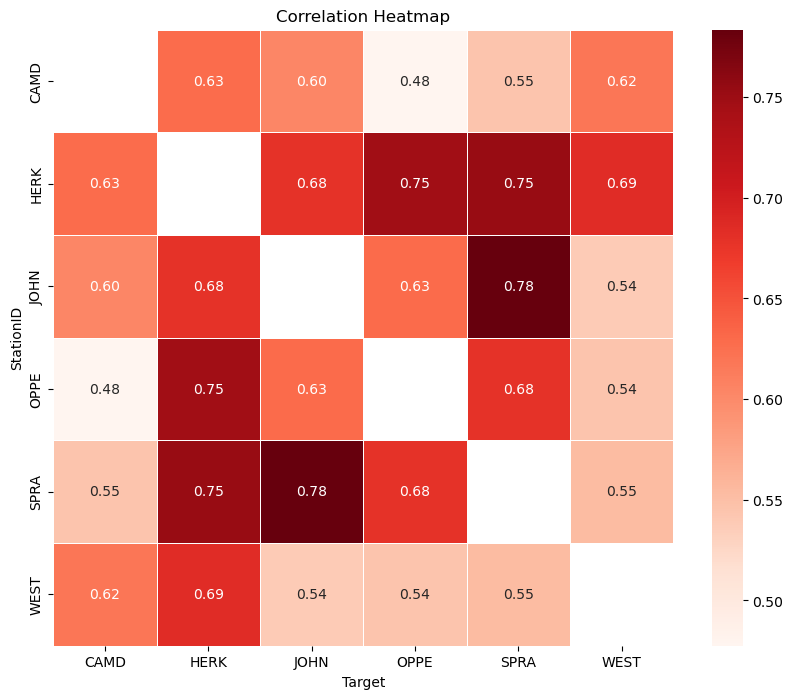

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(df):
    # Assuming 'Correlation' is the first level of a multi-index column in the DataFrame
    # We extract just the correlation data for the heatmap.
    correlation_data = df['Correlation']
    
    # Setting up the figure size for the heatmap.
    plt.figure(figsize=(10, 8))
    
    # Creating the heatmap using seaborn.
    # 'annot=True' will display the correlation values in the heatmap cells.
    # 'cmap' defines the color map. 'coolwarm' is a good choice for correlation as it centers around neutral color for zero.
    sns.heatmap(correlation_data, annot=True, cmap='Reds', fmt=".2f", linewidths=.5)
    
    # Adding title and labels
    plt.title('Correlation Heatmap')
    plt.xlabel('Target')
    plt.ylabel('StationID')
    
    # Displaying the plot.
    plt.show()

# Example of how you would call this function:
plot_correlation_heatmap(corr_df)


# Canonical Correlation

In [166]:
# Initialize a list to store data for DataFrame construction.
data = []

for s in stations:
    x_column = f'{s}_target_error'
    temp_df = df.copy()
    
    # Get station ID from the column name.
    stid = c[:4]  
    X = temp_df.drop(columns = x_column)
    Y = temp_df[[x_column]]
    X_mc = (X - X.mean()) / (X.std())
    Y_mc = (Y - Y.mean()) / (Y.std())
    ca = CCA(n_components=1)
    ca.fit(X_mc, Y_mc) 
    X_c, Y_c = ca.transform(X_mc, Y_mc)
    corr = np.corrcoef(X_c[:, 0], Y_c[:, 0])[0, 1]
    print(corr)

    # Append a tuple with all necessary information.
    data.append((s, corr))

# Create a DataFrame from the list of tuples.
corr_df_CCA = pd.DataFrame(data, columns=['StationID','Correlation'])


corr_df_CCA = corr_df_CCA.set_index('StationID')

corr_df_CCA

0.7132698948458625
0.8616811165576135
0.81715774438111
0.773603204235313
0.84385952076944
0.7283140447358877


,Correlation
StationID,
CAMD,0.713270
HERK,0.861681
JOHN,0.817158
OPPE,0.773603
SPRA,0.843860
WEST,0.728314


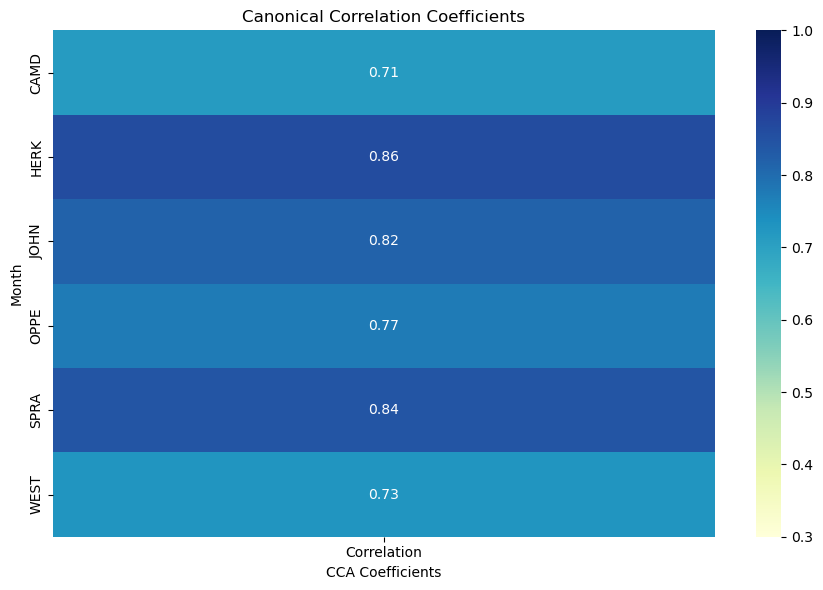

In [167]:
from matplotlib import cm, colors
import matplotlib.pyplot as plt 
import seaborn as sns


fig, ax = plt.subplots(figsize=(9, 6))
ax.set_title(f"Canonical Correlation Coefficients")
ax = sns.heatmap(corr_df_CCA, vmin=0.3, vmax=1, cmap=cm.YlGnBu, annot=True)
ax.set_ylabel("Month")
ax.set_xlabel("CCA Coefficients")
plt.tight_layout()

# Detrended CCA

In [168]:
pip install dcca

/bin/bash: /home/aevans/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


In [169]:
import dcca

In [170]:
a = np.array(df['WEST_target_error'])
b =  np.array(df['SPRA_target_error'])

In [171]:
for t in np.arange(0,5):
    _dc = dcca.detrended_correlation(x=a, y=b, time_scale=1, time_lag=t)
    print(_dc)

0.4366237404475865
0.4466142558856611
0.4346167818170564
0.4060101850572551
0.37016019897425306


In [172]:
data = []

for s in stations:
    x_column = f'{s}_target_error'
    
    for c in df.columns:
        if c == x_column:
            continue
        # Get station ID from the column name.
        stid = c[:4]  
        a = np.array(df[x_column])
        b = np.array(df[c])
        corrs = []
        for t in np.arange(0, 4):  # Time lags from 0 to 9
            _dc = dcca.detrended_correlation(x=a, y=b, time_scale=1, time_lag=t)
            corrs.append(_dc)
        
        # Flatten the corrs list and append it with station ID and target to data
        data.append([stid, s] + corrs)

# Assuming there are 10 time lags, create column names for each time lag
column_names = ['StationID', 'Target'] + [f'Corr_Lag_{i}' for i in range(4)]

# Create a DataFrame from the list of tuples.
corr_df_DCCA = pd.DataFrame(data, columns=column_names)

In [173]:
# Correct the list comprehension to filter out 'Target' and 'StationID'
columns_to_use = [c for c in corr_df_DCCA.columns if c != 'Target' and c != 'StationID']

In [174]:
corr_df_DCCA = corr_df_DCCA.pivot(index ='StationID', columns = 'Target', values = columns_to_use)

In [175]:
corr_df_DCCA

Corr_Lag_0                                                    \
Target          CAMD      HERK      JOHN      OPPE      SPRA      WEST   
StationID                                                                
CAMD             NaN  0.495548  0.478765  0.378273  0.433261  0.490581   
HERK        0.495548       NaN  0.526996  0.583691  0.590317  0.538565   
JOHN        0.478765  0.526996       NaN  0.490953  0.606759  0.422989   
OPPE        0.378273  0.583691  0.490953       NaN  0.530929  0.428879   
SPRA        0.433261  0.590317  0.606759  0.530929       NaN  0.436624   
WEST        0.490581  0.538565  0.422989  0.428879  0.436624       NaN   

          Corr_Lag_1                                ... Corr_Lag_2            \
Target          CAMD      HERK      JOHN      OPPE  ...       JOHN      OPPE   
StationID                                           ...                        
CAMD             NaN  0.465428  0.448153  0.347931  ...   0.407444  0.308340   
HERK        0.493116       NaN  0.493547  0.538727  ...   0.449649  0.486719   
JOHN        0.480633  0.525939       NaN  0.469431  ...        NaN  0.421096   
OPPE        0.386037  0.560890  0.449927       NaN  ...   0.408245       NaN   
SPRA        0.450103  0.587854  0.573526  0.506032  ...   0.529884  0.451777   
WEST        0.463856  0.493683  0.392154  0.392497  ...   0.355126  0.351995   

                              Corr_Lag_3                                \
Target         SPRA      WEST       CAMD      HERK      JOHN      OPPE   
StationID                                                                
CAMD       0.355178  0.418648        NaN  0.371961  0.363814  0.270819   
HERK       0.481603  0.486112   0.404565       NaN  0.399524  0.432685   
JOHN       0.513303  0.413916   0.427161  0.445372       NaN  0.373706   
OPPE       0.436621  0.411450   0.346315  0.459198  0.368102       NaN   
SPRA            NaN  0.434617   0.419445  0.495546  0.479382  0.401543   
WEST       0.350158       NaN   0.363047  0.382376  0.310805  0.311600   

                               
Target         SPRA      WEST  
StationID                      
CAMD       0.311764  0.369452  
HERK       0.425164  0.434825  
JOHN       0.454321  0.381142  
OPPE       0.391694  0.381610  
SPRA            NaN  0.406010  
WEST       0.305979       NaN  

[6 rows x 24 columns]

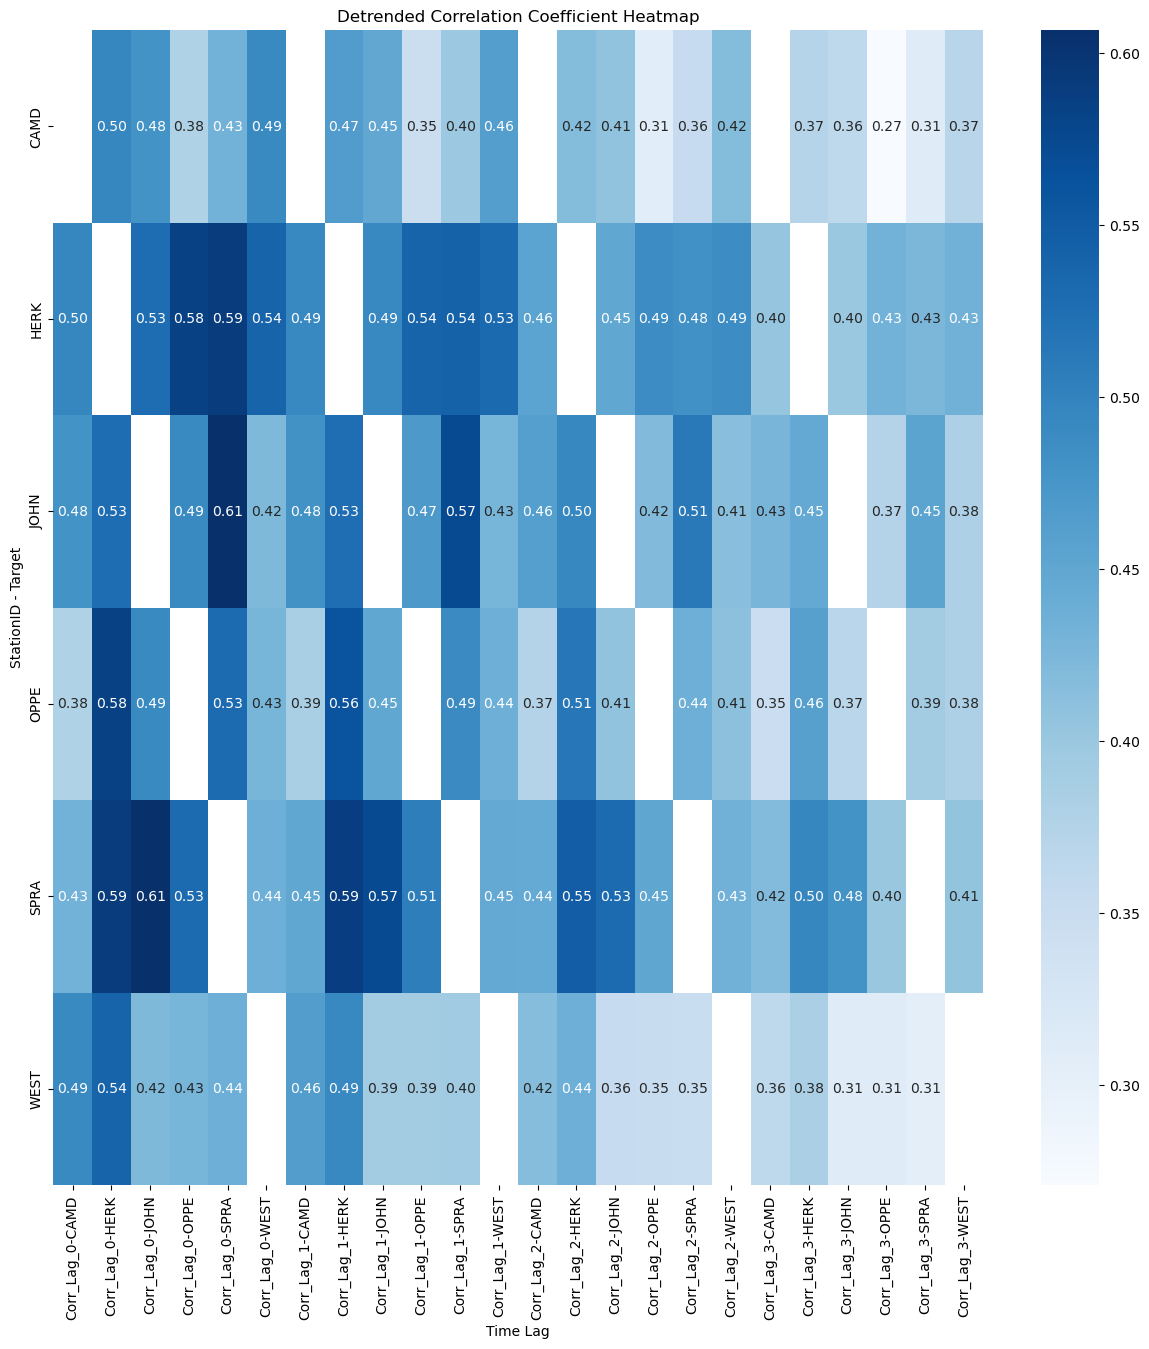

In [176]:
# Create the heatmap
plt.figure(figsize=(15, 15))  # Adjust the figure size as needed
ax = sns.heatmap(corr_df_DCCA, annot=True, cmap='Blues', cbar=True, fmt=".2f")
ax.set_title('Detrended Correlation Coefficient Heatmap')
ax.set_xlabel('Time Lag')
ax.set_ylabel('StationID - Target')
plt.show()